In [1]:
%pylab inline 
import geopandas as gpd 
import rasterio as rio 
import rasterio.mask as mask
import rasterio.features
import rasterio.plot as riop 

import os
from gis_functions import clip_raster_to_geometry, clip_shp_to_geometry
from sinkhole_functions import calc_karst_fraction

Populating the interactive namespace from numpy and matplotlib


In [2]:
datadir = '/home/mcoving/github/sinkhole_analysis/'
basedir = '/home/mcoving/Dropbox/sync/projects/Dolines/'
hu10 = gpd.read_file(basedir+'MonroeCtyWV/NHDPLUS_H_0505_HU4_GDB.gdb', layer='WBDHU10')
# hu12 = gpd.read_file(basedir+'USGS-NHD-DEMs/GDB/NHDPLUS_H_0511_HU4_GDB.gdb', layer='WBDHU12')

In [3]:
second_creek = hu10[hu10.HUC10 == '0505000307']


In [21]:
os.chdir(datadir)
rasterdir = os.path.join(basedir,'MonroeCtyWV/HRNHDPlusRasters0505/')
rasterfile = 'elev_cm.tif'
img_elev = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-')
rasterdir = os.path.join(basedir,'MonroeCtyWV/HRNHDPlusRasters0505/')
rasterfile = 'hydrodem.tif'
img_hyd = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-')
rasterdir = os.path.join(basedir,'MonroeCtyWV/USGS-Sinks-hydrodem/')
rasterfile = 'MonroeCo_Burned_3m_DEM_10kstreams.img'
img_sinks_hyd = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-')
rasterdir = os.path.join(basedir,'MonroeCtyWV/dem/MonroeCo_3m_DEM/')
rasterfile = 'MonroeCo_3m_DEM.img'
img_sinks = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=second_creek,
                              clipname='HUC-0505000307-',
                              #nodata=-9999
                              )


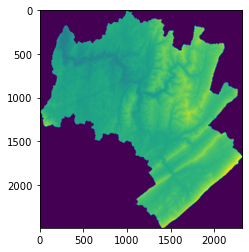

<AxesSubplot:>

In [5]:
riop.show(img_elev)

In [22]:
imgsrc_elev = rio.open(datadir+'HUC-0505000307-elev_cm.tif')
imgsrc_hyd = rio.open(datadir+'HUC-0505000307-hydrodem.tif')
imgsrc_sinks_hyd = rio.open(datadir+'HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams.tif')
imgsrc_sinks = rio.open(datadir+'HUC-0505000307-MonroeCo_3m_DEM.tif')


In [6]:
sinks = clip_shp_to_geometry(clipname='HUC-0505000307-sinks-', 
                             shpdir=os.path.join(basedir, 'MonroeCtyWV','Lidar_derivedcl','MonroeCo_WV_sinkholes_shapefiles'),
                             shpfile='SinkholePolys.shp',
                             geom_df=second_creek,
                             outcrs=imgsrc_elev.crs
                             )

In [7]:
# Rasterize for NHD 1/3 arcsec dems
huc_sinks = gpd.read_file(datadir+'HUC-0505000307-sinks-SinkholePolys.shp')
huc_sinks['ID'] = huc_sinks.index.values
sinks_list = huc_sinks[['geometry','ID']].values.tolist()
out_shape = imgsrc_elev.shape
out_trans = imgsrc_elev.transform
sinks_array = rasterio.features.rasterize(sinks_list,
                fill=0, out_shape= out_shape,
                transform = out_trans)
profile = imgsrc_elev.profile
with rasterio.open(datadir+'HUC-0505000307-sinks-SinkholePolys.tif', 'w', **profile) as dest:
    dest.write(sinks_array.astype(rasterio.int32), 1)


In [23]:
sinks3m = clip_shp_to_geometry(clipname='HUC-0505000307-3m-sinks-', 
                             shpdir=os.path.join(basedir, 'MonroeCtyWV','Lidar_derivedcl','MonroeCo_WV_sinkholes_shapefiles'),
                             shpfile='SinkholePolys.shp',
                             geom_df=second_creek,
                             outcrs=imgsrc_sinks_hyd.crs
                             )
huc_sinks_3m = gpd.read_file(datadir+'HUC-0505000307-3m-sinks-SinkholePolys.shp')
huc_sinks_3m['ID'] = huc_sinks_3m.index.values
sinks_list_3m = huc_sinks_3m[['geometry','ID']].values.tolist()


# Rasterize for 3m Monroe Cty DEM
out_shape = imgsrc_sinks_hyd.shape
out_trans = imgsrc_sinks_hyd.transform
sinks_array_3m = rasterio.features.rasterize(sinks_list_3m,
                fill=-9999, out_shape= out_shape,
                transform = out_trans)
sinks_array_3m.max()


2559

In [25]:
profile = imgsrc_sinks_hyd.profile
profile['dtype'] = 'int32'
with rasterio.open(datadir+'HUC-0505000307-sinks-3m-SinkholePolys.tif', 'w', **profile) as dest:
    dest.write(sinks_array_3m.astype(rasterio.int32), 1)

In [9]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-SinkholePolys.tif')
wat_hyd = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-hydrodem.tif',
                          sinksfile=sinksfile,
                          mean_filter=False,)


./whitebox_tools --run="FillSingleCellPits" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-hydrodem.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-hydrodem-pitfill.tif'

*********************************
* Welcome to FillSingleCellPits *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Prog

In [10]:
wat_elev = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-elev_cm.tif',
                          sinksfile=sinksfile,
                          mean_filter=False)


./whitebox_tools --run="FillSingleCellPits" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-elev_cm-pitfill.tif'

*********************************
* Welcome to FillSingleCellPits *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progre

<AxesSubplot:>

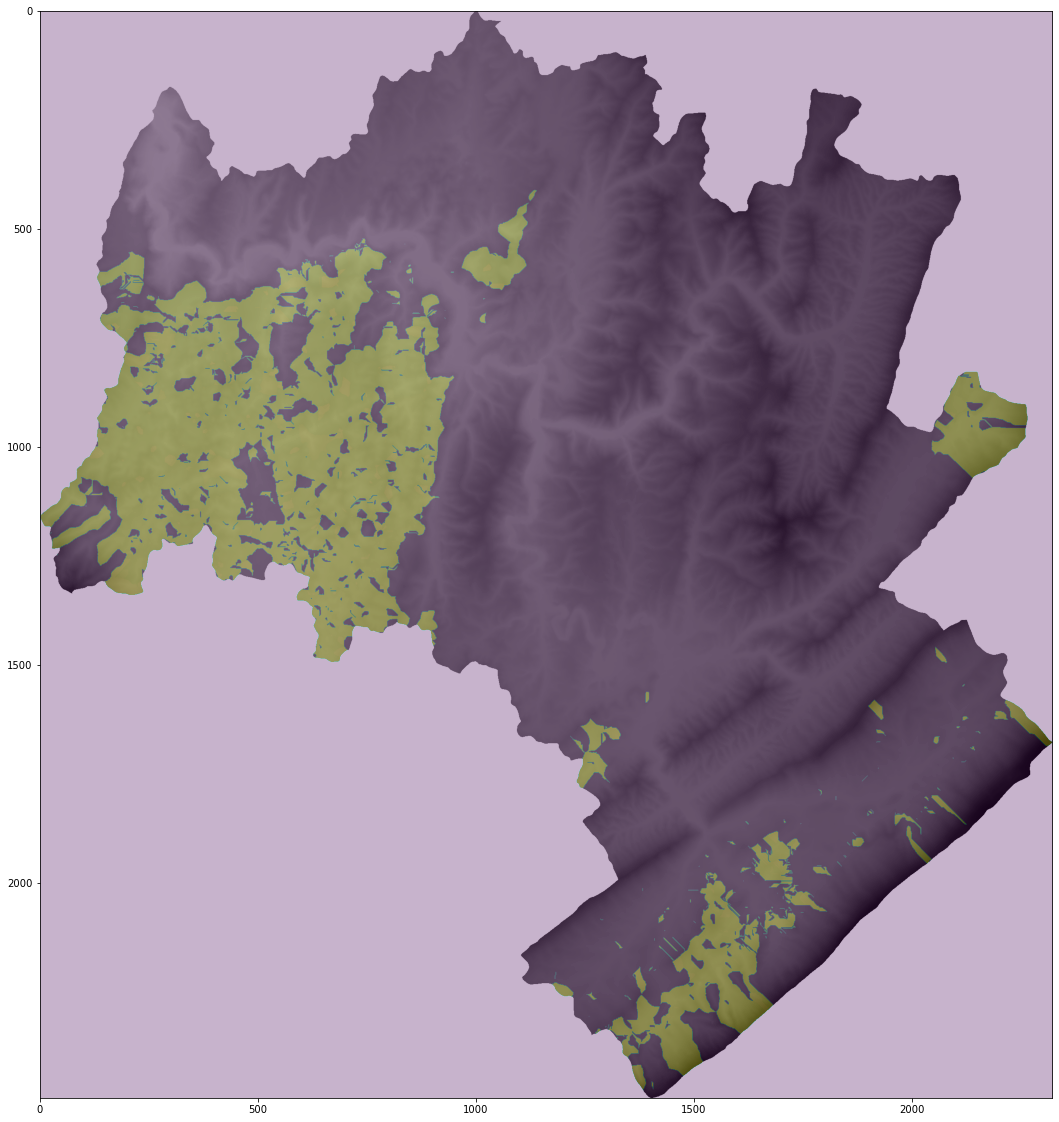

In [11]:
fig, ax = subplots(figsize=(20,20))
riop.show(img_elev, ax=ax, cmap='Greys')
riop.show(wat_elev, ax=ax, alpha=0.3)

In [26]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-3m-SinkholePolys.tif')
wat_sinks_hyd = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams.tif',
                          sinksfile=None,
                          mean_filter=False,
                          fill_pits=False)

./whitebox_tools --run="Sink" --input='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_Burned_3m_DEM_10kstreams-sinks.tif' --zero_background

****************************
* Welcome to Sink          *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Finding pit cells: 25%
Finding pit cells: 50%
Finding pit cells: 75%
Finding pit cells: 100%
Finding depressions: 0%
Finding depressions: 1%
Finding depressions: 2%
Finding depressions: 3%
Finding depressions: 4%
Finding depressions: 5%
Finding depressions: 6%
Finding depressions: 7%
Finding depressions: 8%
Finding depressions: 9%
Finding depressions: 10%
Finding depressions: 11%
Finding depressions: 12%
Finding depressions: 13%
Finding depressions: 14%
Finding depressions: 15%
Finding depressions: 16%
Finding depressions: 17%
Finding depressions: 18%
Finding depressions: 

In [28]:
sinksfile = os.path.join(datadir,'HUC-0505000307-sinks-3m-SinkholePolys.tif')
wat_sinks = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0505000307-MonroeCo_3m_DEM.tif',
                          sinksfile=None,
                          mean_filter=True,
                          fill_pits=True)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_3m_DEM.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0505000307-MonroeCo_3m_DEM-smoothed.tif' --filterx=5 --filtery=5

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 18%
Creating integral images: 19%
Creating i

In [17]:
wat_sinks.max()

-32768

array([[[-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        ...,
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768],
        [-32768, -32768, -32768, ..., -32768, -32768, -32768]]],
      dtype=int32)